## NLP Intro

(based on [YSDA](https://github.com/yandexdataschool/nlp_course) materials )

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [3]:
data.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.


In [ ]:
from sklearn.preprocessing import StandardScaler
# box-cox transforms the data to make it more normal

def box_cox(x, lmbda):
    if lmbda == 0:
        return np.log(x + 1) # == np.log1p(x)
    else:
        return (x**lmbda - 1) / lmbda

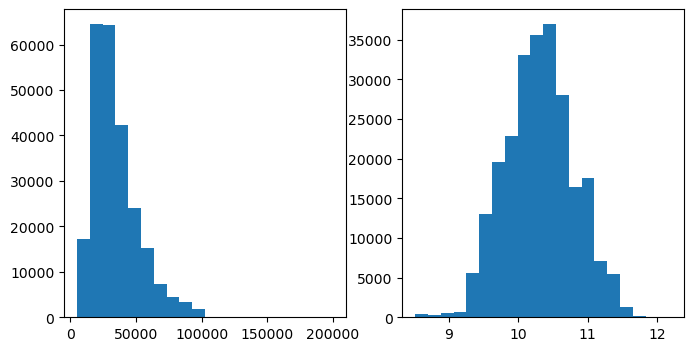

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [6]:
text_columns = ["Title", "FullDescription"]
TARGET_COLUMN = "Log1pSalary"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
99864,69538130,Oracle Consultant (ERP),MCS Group are currently working with one of Ir...,Belfast,Belfast,full_time,permanent,MCS Group,IT Jobs,"40,000 - 50,000",45000,nijobfinder.co.uk,10.714440
170048,71352930,Pensions Administration Manager,Are you looking for a change and a move to Sun...,Malta Island,UK,NaN,permanent,Sammons Pensions,Accounting & Finance Jobs,GBP35000 - 48000 per annum,41500,professionalpensionsjobs.com,10.633472
146878,70754568,Business Intelligence Operational Analyst,Business Intelligence Operational Analyst Te...,Haywards Heath,Haywards Heath,NaN,NaN,Centrepoint Recruitment Consultants,Admin Jobs,40000 - 48000 per annum,44000,MyUkJobs,10.691968


### Tokenization

Applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

We have to lowercase and tokenize all texts under `Title` and `FullDescription` columns.


In [8]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [9]:
import nltk 
tokenizer = nltk.tokenize.WordPunctTokenizer()


In [10]:
tokenizer.tokenize(data["FullDescription"][2])

['Mathematical',
 'Modeller',
 '/',
 'Simulation',
 'Analyst',
 '/',
 'Operational',
 'Analyst',
 'Basingstoke',
 ',',
 'Hampshire',
 'Up',
 'to',
 '****',
 'K',
 'AAE',
 'pension',
 'contribution',
 ',',
 'private',
 'medical',
 'and',
 'dental',
 'The',
 'opportunity',
 'Our',
 'client',
 'is',
 'an',
 'independent',
 'consultancy',
 'firm',
 'which',
 'has',
 'an',
 'opportunity',
 'for',
 'a',
 'Data',
 'Analyst',
 'with',
 '35',
 'years',
 'experience',
 '.',
 'The',
 'role',
 'will',
 'require',
 'the',
 'successful',
 'candidate',
 'to',
 'demonstrate',
 'their',
 'ability',
 'to',
 'analyse',
 'a',
 'problem',
 'and',
 'arrive',
 'at',
 'a',
 'solution',
 ',',
 'with',
 'varying',
 'levels',
 'of',
 'data',
 'being',
 'available',
 '.',
 'Essential',
 'skills',
 'Thorough',
 'knowledge',
 'of',
 'Excel',
 'and',
 'proven',
 'ability',
 'to',
 'utilise',
 'this',
 'to',
 'create',
 'powerful',
 'decision',
 'support',
 'models',
 'Experience',
 'in',
 'Modelling',
 'and',
 'Simu

In [12]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

data["Title"] = [
    ' '.join(tokenizer.tokenize(str(text).lower())) for text in data["Title"]
]
data["FullDescription"] = [
    ' '.join(tokenizer.tokenize(str(text).lower())) for text in data["FullDescription"]
]

In [13]:
print("Tokenized:")
print(data["FullDescription"][2::100000])

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Next step is to build __Vocabulary__ : a set of all unique tokens with token to index and index to token mappings.

Note that not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [16]:
from collections import Counter
token_counts = Counter()

for column in text_columns:
    texts = data[column].values
    
    for text in texts:
        token_counts.update(text.split())

# for column in text_columns:
#     texts = data[column].values
    
#     for t in texts:
#         words = t.split()
#         for word in words:
#             token_counts[word] += 1

In [17]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Get a list of tokens that occur at least 10 times

In [18]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]# YOUR CODE HERE

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [19]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [22]:
tokens[:10]

['UNK',
 'PAD',
 'engineering',
 'systems',
 'analyst',
 'stress',
 'engineer',
 'glasgow',
 'modelling',
 'and']

Build an inverse vocabulary

In [23]:
token_to_id = {token: indx for indx, token in enumerate(tokens)}# YOUR CODE HERE

In [24]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


Now we will use vocabulary to convert text

In [25]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [30]:
tokens[1]

'PAD'

In [33]:
import torch

a = torch.randn(5)
b = torch.randn(5)


In [34]:
torch.stack([a, b], dim=0).shape

torch.Size([2, 5])

In [26]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


## Deep learning part

In [35]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [36]:
TARGET_COLUMN = 'Log1pSalary'

In [38]:
# nn.Linear(128, 4096) # train: ~[bs, 4096 * (1 - 0.2)] || test: [bs, 4096]
# nn.Dropout(0.2)      # train: [bs, 4096]  || test: * (1 - 0.2)
# nn.Linear(4096, 1)   # [bs, 4096] -> [bs, 1]

Dropout(p=0.2, inplace=False)


In [39]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len], 'FullDescription': int64[batch, max_len]}
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [40]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[   18,   287,   359,     1,     1,     1,     1],
         [ 2863,    11,    12,    13,    55,    37, 12109],
         [ 2833,   618,   858,    63,  7104,  7105,    64]]),
 'FullDescription': tensor([[   18,   287,   359,  1408,   561,    18,   287,   359,  1464,  1408],
         [ 2863,    11,    12,    13,    55,    37, 12109,  1767,  1166,    74],
         [  142,  1617,  8830,  1314,  1464,   559,   560,   561,   618,   858]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}

In [63]:
# [bs, seq_len, emb_dim]
a = torch.randn(3, 10, 16)

# [seq_len, bs, emb_dim]


In [64]:
from torch import nn


In [66]:
gru = nn.GRU(input_size=16, hidden_size=64, bidirectional=True, batch_first=True)
lstm = nn.LSTM(input_size=16, hidden_size=64, batch_first=True)

In [78]:
gru_out, gru_hidden = gru(a)
lstm_out, (lstm_hidden, _) = lstm(a)

In [73]:
gru_out.shape # [3, 10, 128]
gru_hidden.shape # [1 + bidirectional, 3, 64] 

gru_hidden = gru_hidden.view(gru_hidden.size(1), -1)

In [74]:
gru_hidden.size()

torch.Size([3, 128])

In [83]:
from torch import nn

class RNNRegressor(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int = 64, hid_size: int = 64, dropout: float = 0.2):
        super().__init__()
        
        self.title_emb = nn.Embedding(vocab_size, emb_size)
        self.descr_emb = nn.Embedding(vocab_size, emb_size)

        self.title_gru = nn.GRU(input_size=emb_size, hidden_size=hid_size, batch_first=True, dropout=dropout)
        self.descr_gru = nn.GRU(input_size=emb_size, hidden_size=hid_size, batch_first=True, dropout=dropout)
        
        # self.cat_encoder = nn.Linear(num_cat_features, hid_size)
        self.fully_connected = nn.Sequential(
            nn.Linear(2 * hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1),
        )
    
    def forward(self, batch):
        title = batch['Title'] # [bs, seq_len]
        descr = batch['FullDescription']
        
        # squeeze: [1, a, b, 1, c, 1, 1, d] -> [a, b, c, d]
        embed_title = self.title_emb(title) # [bs, seq_len, emb_dim]
        _, title_hidden = self.title_gru(embed_title) # [1, bs(?=1), hid_size]
        title_hidden = title_hidden.squeeze(0) # [bs, hid_size]
        
        embed_descr = self.descr_emb(descr) # [bs, seq_len, emb_dim]
        _, descr_hidden = self.descr_gru(embed_descr) # [1, bs, hid_size]
        descr_hidden = descr_hidden.squeeze(0) # [bs, hid_size]

        # cat_features = self.cat_encoder(batch['Categorical']) # [bs, hid_size]
        # concated = torch.cat([title_hidden, descr_hidden, cat_features], dim=1) # [bs, 3 * hid_size]

        concated = torch.cat([title_hidden, descr_hidden], dim=1) # [bs, 2 * hid_size]
        output = self.fully_connected(concated) # [bs, 1]
        return output.squeeze(1) # [bs]
        

In [84]:
model = RNNRegressor(len(tokens), emb_size=64, hid_size=64, dropout=0.2)
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

/Users/amarkov/.miniconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### Training

In [85]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=torch.device('cpu'), **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [86]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 5
DEVICE = torch.device('cpu')

In [87]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [88]:
model = RNNRegressor(len(tokens), emb_size=64, hid_size=64, dropout=0.2).to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        y_true = batch.pop(TARGET_COLUMN)
        y_pred = model(batch)
        
        loss = criterion(y_pred, y_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        
    print_metrics(model, data_val)

      

epoch: 0


/Users/amarkov/.miniconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/8z/rdxqfjbs0xx8flpxsgkvkxgw0000gn/T/ipykernel_1735/3993476165.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in tqdm.tqdm_notebook(enumerate(


  0%|          | 0/1529 [00:00<?, ?it/s]

KeyboardInterrupt: 